# **scNET: Learning Context-Specific Gene and Cell Embeddings by Integrating Single-Cell Gene Expression Data with Protein-Protein Interaction Information**

# This tutorial demonstrates how to use scNET with a multi-batch dataset using BBKNN




**Install scnet & bbknn using pip**

**It may be necessary to restart (not delete) the runtime after installing ScENT in Google Colab. We are working on fixing this issue in future releases.**

In [ ]:
!pip install scnet
!pip install bbknn

**Download example data**

**These are CD8 T cells from WT and KO models exposed to MHC II tumor microenvironments.**







In [3]:
import gdown
download_url = f'https://drive.google.com/uc?id=1_8iDY4aiCLeuIdkTrRBBkuKl5wykEboE'
output_path = './example_integration.h5ad'
gdown.download(download_url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1_8iDY4aiCLeuIdkTrRBBkuKl5wykEboE
From (redirected): https://drive.google.com/uc?id=1_8iDY4aiCLeuIdkTrRBBkuKl5wykEboE&confirm=t&uuid=e810a423-7e96-4653-912c-0597fa65c9db
To: /content/example_intergration.h5ad
100%|██████████| 110M/110M [00:01<00:00, 68.2MB/s]


'./example_intergration.h5ad'

**Basic Preprocessing and BBKNN Graph Construction.**


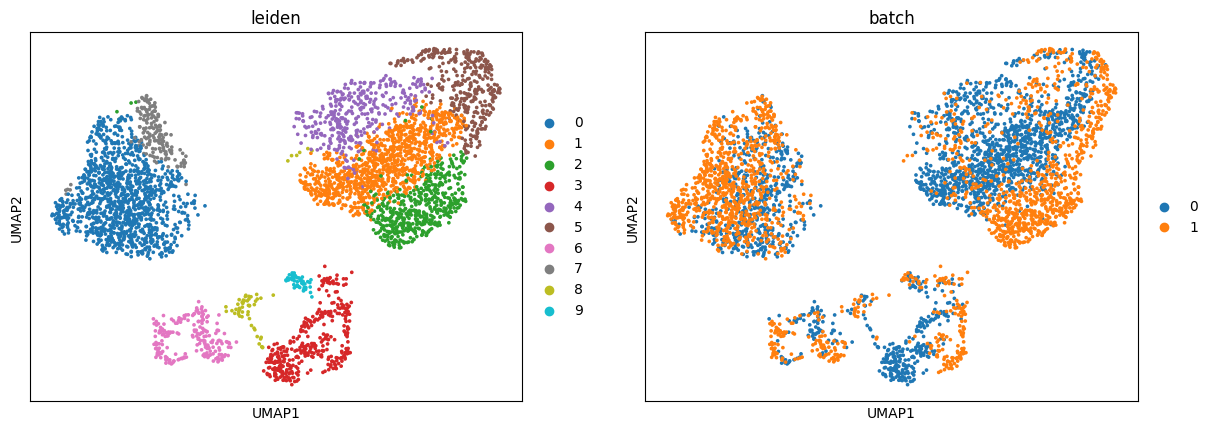

In [14]:
import scanpy as sc
import bbknn
import sys

def pre_processing(adata,n_neighbors):
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=10)

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata.copy()
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=15)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.5)
    return adata

adata = pre_processing(sc.read('example_integration.h5ad'),15)
sc.pl.umap(adata, color=['leiden','batch'])
bbknn.bbknn(adata, batch_key='batch', neighbors_within_batch=15)



# Import scNET and model traning

In [22]:
import scNET
#For faster processing in medium to large datasets (e.g. 30K or above cells), the maximum cells batch size can be increased depending on the available GPU memory.

#For GPU with 24GB memory
scNET.main.MAX_CELLS_BATCH_SIZE = 3000

#for GPU with 40GB memory
scNET.main.MAX_CELLS_BATCH_SIZE = 4000

#For GPU with 80GB memory or more
scNET.main.MAX_CELLS_BATCH_SIZE = 8000

#otherwize, do not change the default value

In [ ]:
#To control the cutoff of gene expression, the minimum precetage of cells expressing a gene can be adjusted. The default all expressed genes are considered.
#For example, to consider genes expressed in at least 5% of cells
#scNET.main.EXPRESSION_CUTOFF = 0.05

In [15]:
#For larger dataset (10K or above), containing larger number of subcommunities, the number of encoder layers could be increased to 4 or more. the default value is 3.
scNET.main.NUM_LAYERS = 3

In [ ]:
#To control the number of deifferentially expressed genes, the default value is 2000
#For example, to consider 3000 DE genes
scNET.main.DE_GENES_NUM = 3000

## run_scNET arguments:
 **obj (AnnData, optional):** AnnData obj.

  **pre_processing_flag (bool, optional):** If True, perform pre-processing steps.

  **human_flag (bool, optional):** Controls gene name casing in the network.

  **number_of_batches (int, optional):** Number of mini-batches for the training.

  **split_cells (bool, optional):** If True, split by cells instead of edges during training. If using A100 could be True (for 10K cells or less)

  **n_neighbors (int, optional):** Number of neighbors for building the adjacency graph.

  **max_epoch (int, optional):** Max number of epochs for model training (recommended 250-300, and for larger dataset consider also 300-350).

  **model_name (str, optional):** Identifier for saving the model outputs.
  
  **save_model_flag (bool, optional):** If True, save the trained model.

  **bbknn_flag (bool, optional):** If True, use BBKNN for building the adjacency graph.

In [2]:
import scanpy as sc
scNET.run_scNET(adata, pre_processing_flag=False, human_flag=False, number_of_batches=4, split_cells=True, max_epoch=250, model_name = "integration", bbknn_flag=True)


/content/scNET/scNET/Data/format_h_sapiens.csv
N genes: (8726, 4231)
Highly variable genes: 3000


Training: 100%|██████████| 250/250 [21:47<00:00,  5.23s/it]

Best Network AUC: 0.8849648791684906



# Using the model's outputs

**Load all the relevant embeddings**


**Create Scanpy object based on the reconstructed gene expression**


In [3]:
embedded_genes, embedded_cells, node_features , out_features =  scNET.load_embeddings("integration")
recon_obj = scNET.create_reconstructed_obj(node_features, out_features, adata)

**Plot marker genes**

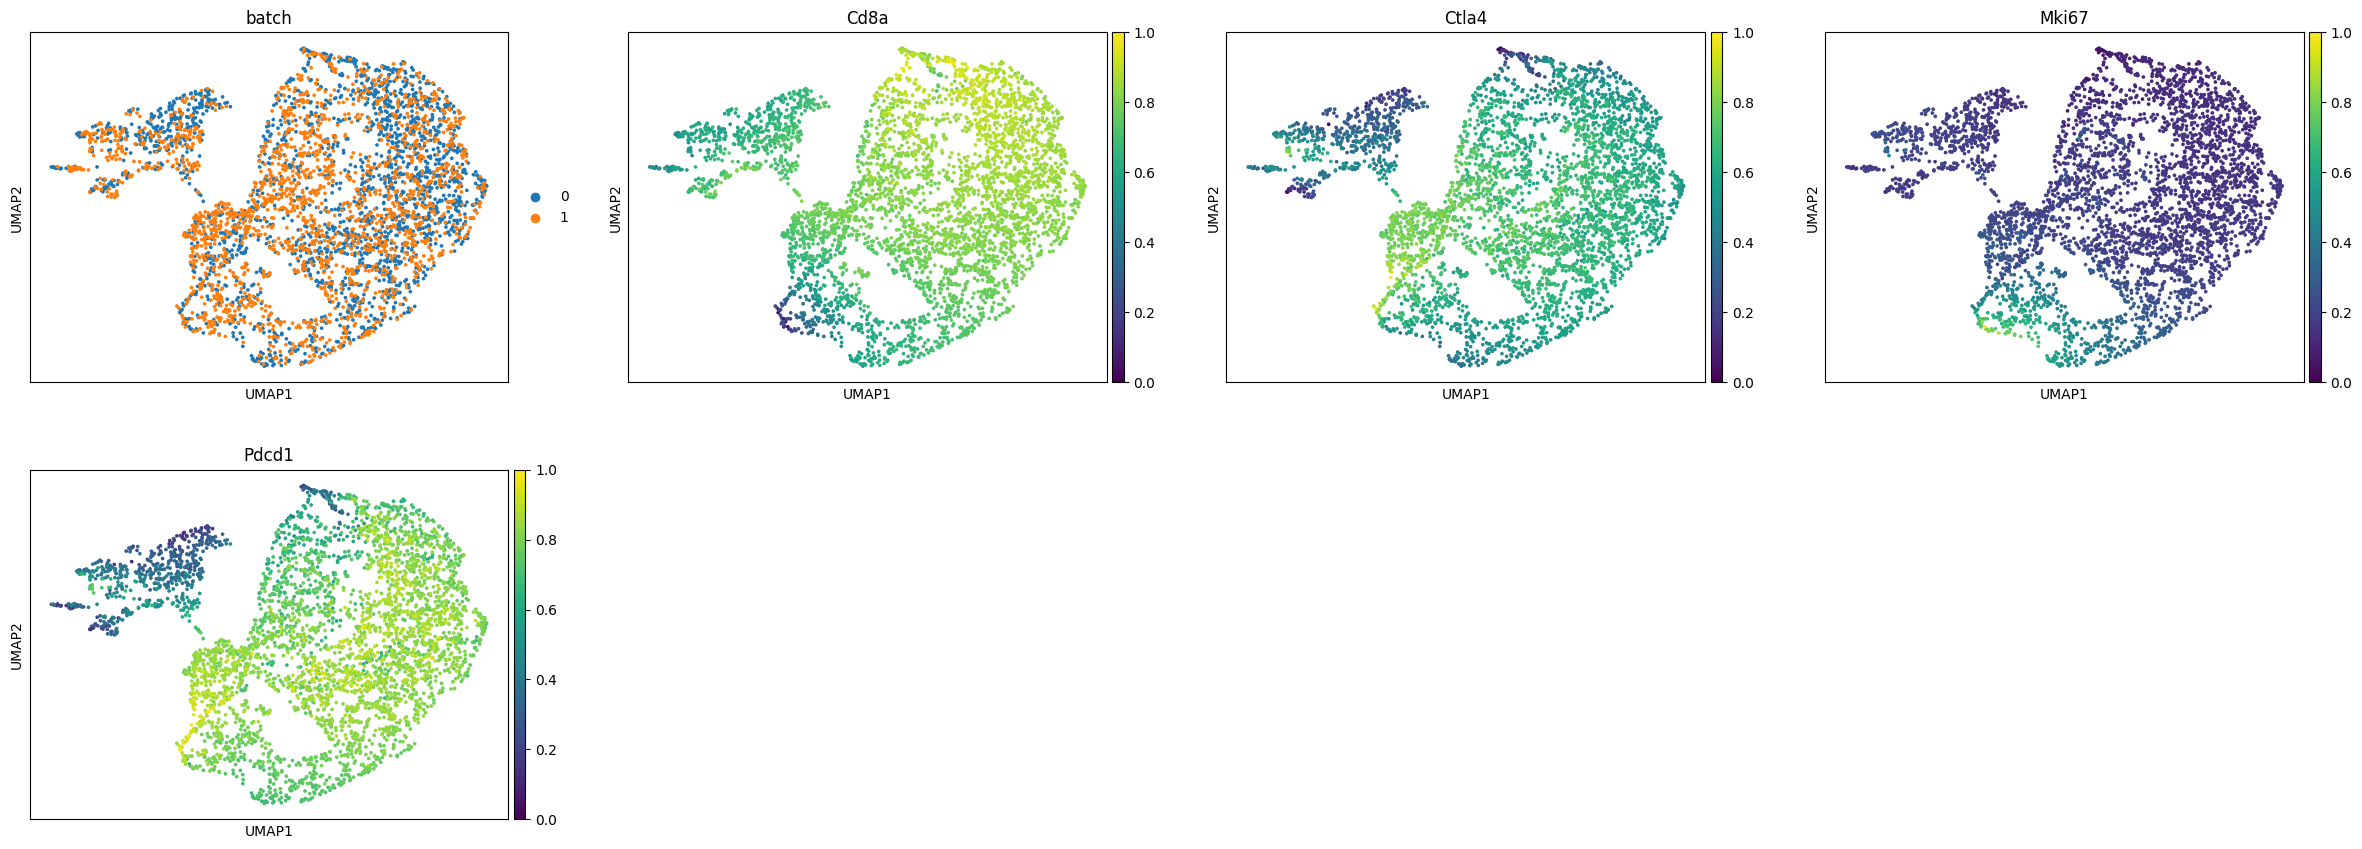

In [13]:
sc.pl.umap(recon_obj, color=["batch","Cd8a","Ctla4","Mki67","Pdcd1"], show=True)

**Propagation based signature projection for exhausted of Tcells**



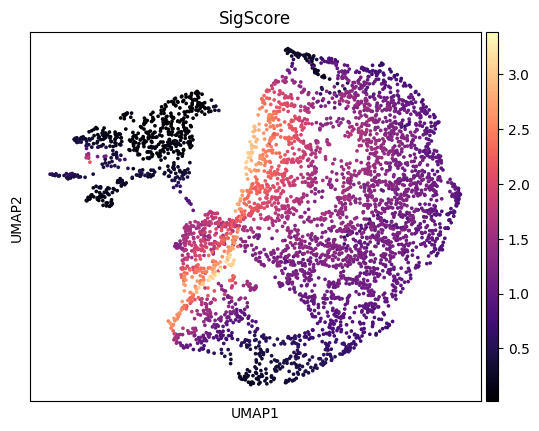

array([1.58728126, 1.5036927 , 0.86589302, ..., 0.42718322, 0.88457367,
       1.23343328])

In [5]:
scNET.run_signature(recon_obj, up_sig=["Pdcd1","Lck","Lag3","Tigit","Ctla4","Havcr2"],alpha = 0.9)

**And for Tumor aggression**

**Propagation based signature projection for Naive of Tcells**

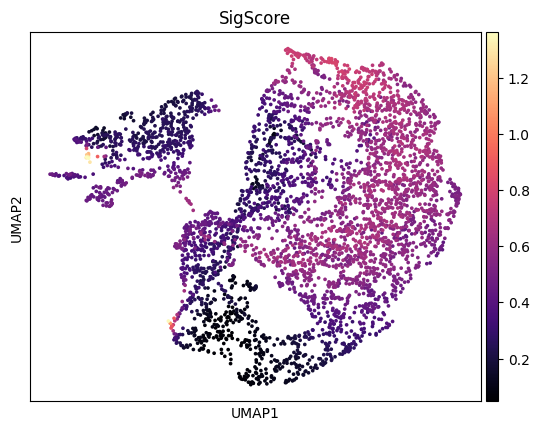

array([0.46435429, 0.41252402, 0.48186151, ..., 0.36290624, 0.62191855,
       0.62597823])

In [9]:

scNET.run_signature(recon_obj, up_sig=["Cd62l","Lef1","Il7r","Ccr7","S1pr1"],alpha = 0.9)

**Propagation based signature projection for Proliferating of Tcells**

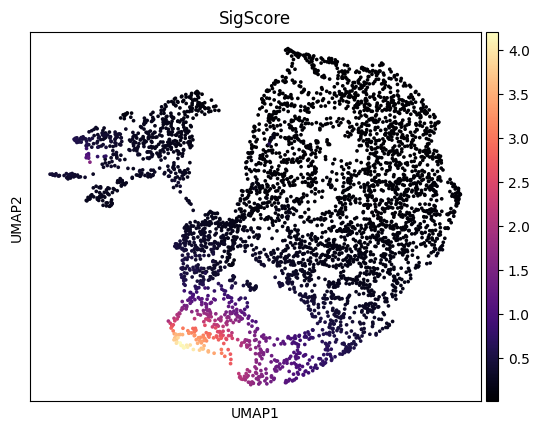

array([0.01724092, 3.55491819, 0.13479916, ..., 0.34677778, 0.04918277,
       0.07558021])

In [10]:
scNET.run_signature(recon_obj, up_sig=["Mki67","Cdk1","Cdk2","Il2ra"],alpha = 0.9)